In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("map").getOrCreate()

In [105]:
kill_0 = 's3://502pubg/clean/kill.parquet'
kill = spark.read.parquet(kill_0)

In [106]:
kill.printSchema()
kill.count()

root
 |-- killed_by: string (nullable = true)
 |-- killer_placement: double (nullable = true)
 |-- killer_position_x: integer (nullable = true)
 |-- killer_position_y: integer (nullable = true)
 |-- map: string (nullable = true)
 |-- time: integer (nullable = true)
 |-- victim_placement: double (nullable = true)
 |-- victim_position_x: integer (nullable = true)
 |-- victim_position_y: integer (nullable = true)
 |-- id: long (nullable = true)



58923976

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import imread
from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [170]:
edf = kill.filter("map == 'ERANGEL'")
mdf = kill.filter("map == 'MIRAMAR'")

In [ ]:
from pyspark.ml.linalg import DenseVector
a = DenseVector(edf.select('victim_position_x').rdd.map(lambda x: x[0]).collect()) 
print(a)

In [178]:
def killer_victim_df_maker(kill_0):
    #find the position of the killers and players who were killed on the map 
    df = edf
    victim_x_df = df.select('victim_position_x')
    victim_y_df = df.select('victim_position_y')
    killer_x_df = df.select('killer_position_x')
    killer_y_df = df.select('killer_position_y')
    #ravel()the matrix
    victim_x_s = pd.Series(victim_x_df.values.ravel('F'))
    victim_y_s = pd.Series(victim_y_df.values.ravel('F'))
    killer_x_s = pd.Series(killer_x_df.values.ravel('F'))
    killer_y_s = pd.Series(killer_y_df.values.ravel('F'))
    
    vdata = {'x':victim_x_s, 'y':victim_y_s}
    kdata = {'x':killer_x_s, 'y':killer_y_s}
    
    victim_df = pd.DataFrame(data = vdata).dropna(how = 'any')
    victim_df = victim_df[victim_df['x'] > 0]
    killer_df = pd.DataFrame(data = kdata).dropna(how = 'any')
    killer_df = killer_df[killer_df['x'] > 0]
    return killer_df, victim_df

In [179]:
ekdf,evdf = killer_victim_df_maker(edf)
mkdf,mvdf = killer_victim_df_maker(mdf)

AttributeError: 'DataFrame' object has no attribute 'values'

In [15]:
print(ekdf.head(10))#the killers positions on the map "erangel"
print(evdf.head(10))#the players position who were killed on the map "erangel"
print(mkdf.head(10))#the killers positions on the map "miramar"
print(mvdf.head(10))#the players position who were killed on the map

        x       y
0  526713  669857
1  462594  644537
2  360094  394891
3  335182  157544
4  205344  270663
5  469621  647893
6  302518  579473
7  624428  602356
8  450102  620974
9  281149  558808
         x       y
1   463091  643535
2   360259  396052
3   333915  157494
4   209850  270024
5   459994  646792
6   297147  579977
7   626641  614474
8   449996  621004
9   288445  559878
10  637573  461594
        x       y
0  526713  669857
1  462594  644537
2  360094  394891
3  335182  157544
4  205344  270663
5  469621  647893
6  302518  579473
7  624428  602356
8  450102  620974
9  281149  558808
         x       y
1   463091  643535
2   360259  396052
3   333915  157494
4   209850  270024
5   459994  646792
6   297147  579977
7   626641  614474
8   449996  621004
9   288445  559878
10  637573  461594
4035806 3961863 4035806 3961863


In [38]:
plot_data_ev = evdf[['x','y']].values
plot_data_ek = ekdf[['x','y']].values
plot_data_mv = mvdf[['x','y']].values
plot_data_mk = mkdf[['x','y']].values

In [39]:
plot_data_ev = plot_data_ev * 4040 /800000
plot_data_ek = plot_data_ek * 4040 /800000
plot_data_mv = plot_data_mv * 976 /800000
plot_data_mk = plot_data_mk * 976 /800000

In [45]:
print(plot_data_ev)

[[ 2338.60955 -2118.85737]
 [ 1819.30795  2000.0626 ]
 [ 1686.27075   795.3447 ]
 ...
 [ 2236.04405 -2223.73072]
 [ 1439.0985    671.52375]
 [ 1583.7709    958.91925]]


In [34]:
def heatmap(x, y, s, bins = 100):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins = bins)
    heatmap = gaussian_filter(heatmap, sigma = s)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent

In [35]:
bg = imread('erangel.jpg')
hmap, extent = heatmap(plot_data_ev[:,0], plot_data_ev[:,1], 1.5, bins =800)
alphas = np.clip(Normalize(0, hmap.max()/100, clip=True)(hmap)*1.5,0.0,1.)
colors = Normalize(hmap.max()/100, hmap.max()/20, clip=True)(hmap)
colors = cm.bwr(colors)
colors[..., -1] = alphas

In [36]:
hmap2, extent2 = heatmap(plot_data_ek[:,0],plot_data_ek[:,1],1.5, bins = 800)
alphas2 = np.clip(Normalize(0, hmap2.max()/100, clip = True)(hmap2)*1.5, 0.0, 1.)
colors2 = Normalize(hmap2.max()/100, hmap2.max()/20, clip=True)(hmap2)
colors2 = cm.RdBu(colors2)
colors2[...,-1] = alphas2

Text(0.5, 1.0, 'Deathrate in Erangel')

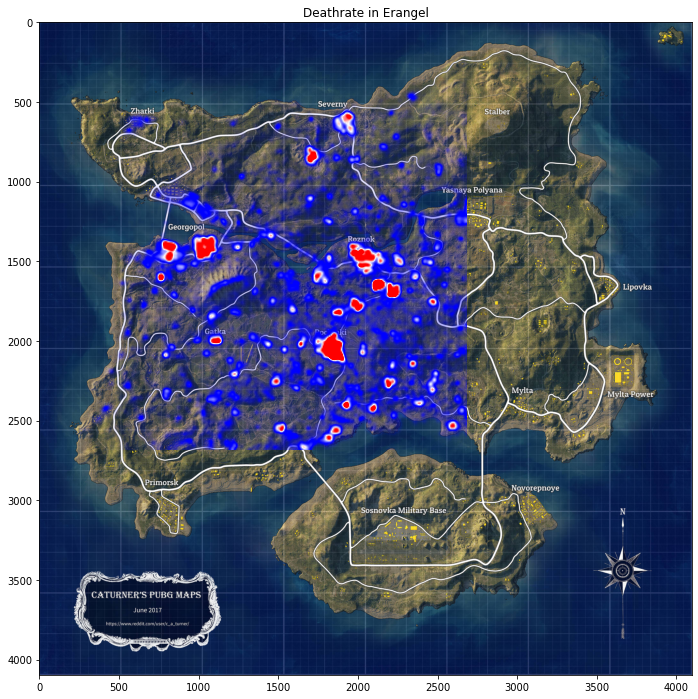

In [37]:
#erangel Deathrate
fig, ax = plt.subplots(figsize = (12,12))
ax.set_xlim(0, 4096);ax.set_ylim(0, 4096)
ax.imshow(bg)
ax.imshow(colors, extent = extent, origin = 'lower', cmap = cm.bwr, alpha = 1)
plt.gca().invert_yaxis()
plt.title('Deathrate in Erangel')

Text(0.5, 1.0, 'Killrate in Erangel')

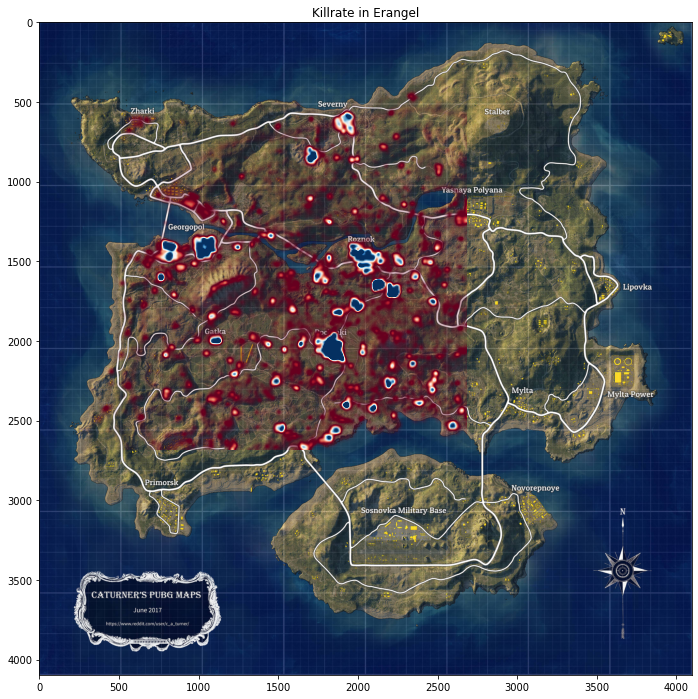

In [27]:
#Erangel Killrate
fig, ax = plt.subplots(figsize = (12,12))
ax.set_xlim(0, 4096); ax.set_ylim(0, 4096)
ax.imshow(bg)
ax.imshow(colors2, extent = extent2, origin = 'lower', cmap = cm.RdBu, alpha = 1)
plt.gca().invert_yaxis()
#plt.colorbar()
plt.title('Killrate in Erangel')

In [24]:
def divbutnotbyzero(a, b):
    c = np.zeros(a.shape)
    for i, row in enumerate(b):
        for j, el in enumerate(row):
            if el == 0:#如果击杀率等于0的话
                c[i][j] = a[i][j]#c值就等于死亡率的值
            else:
                c[i][j] = a[i][j]/el#击杀/死亡
    return c

In [25]:
hmap, extent = heatmap(plot_data_ev[:,0], plot_data_ev[:,1], 0, bins = 800)
hmap2, extent2 = heatmap(plot_data_ek[:,0], plot_data_ek[:,1], 0, bins = 800)
hmap3 = divbutnotbyzero(hmap, hmap2)
alphas = np.clip(Normalize(0, hmap3.max()/100, clip=True)(hmap)*1.5, 0.0,1.)
colors = Normalize(hmap3.max()/100, hmap3.max()/20, clip=True)(hmap)
colors = cm.rainbow(colors)
colors[...,-1] = alphas

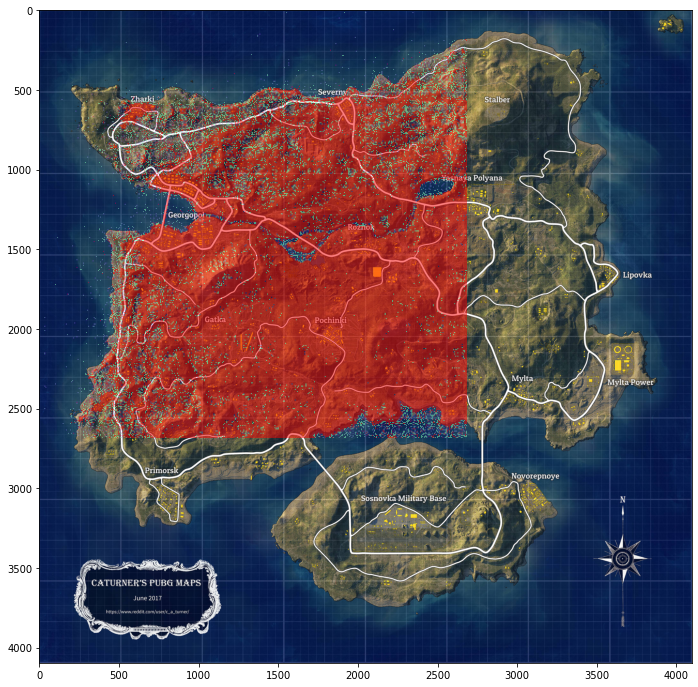

In [28]:
fig, ax = plt.subplots(figsize = (12, 12))
ax.set_xlim(0,4096); ax.set_ylim(0, 4096)
ax.imshow(bg)
ax.imshow(colors, extent = extent, origin = 'lower', cmap = cm.rainbow, alpha = 0.5)
plt.gca().invert_yaxis()